In [17]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date
import pyspark.sql.functions as F
import seaborn as sns
import geopandas as gpd
import numpy as np
import pandas as pd
spark = SparkSession.builder.getOrCreate()

path = "./data/donnees-hospitalieres-nouveaux-covid19-2021-01-20-19h03.csv"
df = spark.read.options(header=True, inferSchema=True, sep=";").csv(path)
df.dtypes

# création d'un colonne avec le bon format date
df = df.withColumn("date", to_date(df["jour"], "yyyy-MM-dd"))

df.printSchema()

root
 |-- dep: string (nullable = true)
 |-- jour: string (nullable = true)
 |-- incid_hosp: integer (nullable = true)
 |-- incid_rea: integer (nullable = true)
 |-- incid_dc: integer (nullable = true)
 |-- incid_rad: integer (nullable = true)
 |-- date: date (nullable = true)



In [18]:
## Documentation

# incid_hosp; string; Nombre quotidien de personnes nouvellement hospitalisées
# incid_rea; integer; Nombre quotidien de nouvelles admissions en réanimation
# incid_dc; integer; Nombre quotidien de personnes nouvellement décédées
# incid_rad; integer; Nombre quotidien de nouveaux retours à domicile
# échantillon
df.take(5)

[Row(dep='01', jour='2020-03-19', incid_hosp=1, incid_rea=0, incid_dc=0, incid_rad=0, date=datetime.date(2020, 3, 19)),
 Row(dep='02', jour='2020-03-19', incid_hosp=38, incid_rea=8, incid_dc=10, incid_rad=15, date=datetime.date(2020, 3, 19)),
 Row(dep='03', jour='2020-03-19', incid_hosp=2, incid_rea=0, incid_dc=0, incid_rad=6, date=datetime.date(2020, 3, 19)),
 Row(dep='04', jour='2020-03-19', incid_hosp=1, incid_rea=0, incid_dc=0, incid_rad=1, date=datetime.date(2020, 3, 19)),
 Row(dep='05', jour='2020-03-19', incid_hosp=4, incid_rea=0, incid_dc=0, incid_rad=1, date=datetime.date(2020, 3, 19))]

In [3]:
# compte le nombre de cas déclaré par journée
incid_hosp = df.groupBy("date").sum("incid_hosp")
incid_hosp.orderBy("date").show()

+----------+---------------+
|      date|sum(incid_hosp)|
+----------+---------------+
|2020-03-19|           2229|
|2020-03-20|           1256|
|2020-03-21|           1540|
|2020-03-22|           1534|
|2020-03-23|           2053|
|2020-03-24|           2618|
|2020-03-25|           3166|
|2020-03-26|           3097|
|2020-03-27|           3059|
|2020-03-28|           3353|
|2020-03-29|           2685|
|2020-03-30|           3108|
|2020-03-31|           4146|
|2020-04-01|           4281|
|2020-04-02|           3845|
|2020-04-03|           3627|
|2020-04-04|           2822|
|2020-04-05|           1931|
|2020-04-06|           2754|
|2020-04-07|           3277|
+----------+---------------+
only showing top 20 rows



<AxesSubplot:title={'center':'Nouvelles hospitalisations enregistrées par jour au niveau national'}, xlabel='date', ylabel='nouveaux cas'>

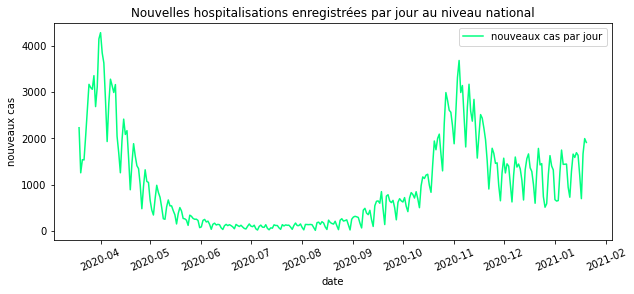

In [22]:
panda_data_frame = incid_hosp.toPandas()
panda_data_frame.plot(
    x="date",
    y="sum(incid_hosp)",
    ylabel="nouveaux cas",
    colormap='winter_r', 
    figsize=(10, 4), 
    rot=23, 
    title="Nouvelles hospitalisations enregistrées par jour au niveau national",
    label="nouveaux cas par jour",
)

<AxesSubplot:>

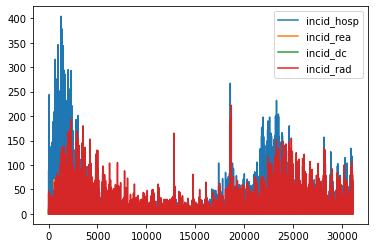

In [25]:
df.orderBy("date").toPandas().plot(kind="line")

<AxesSubplot:xlabel='month', ylabel='mean'>

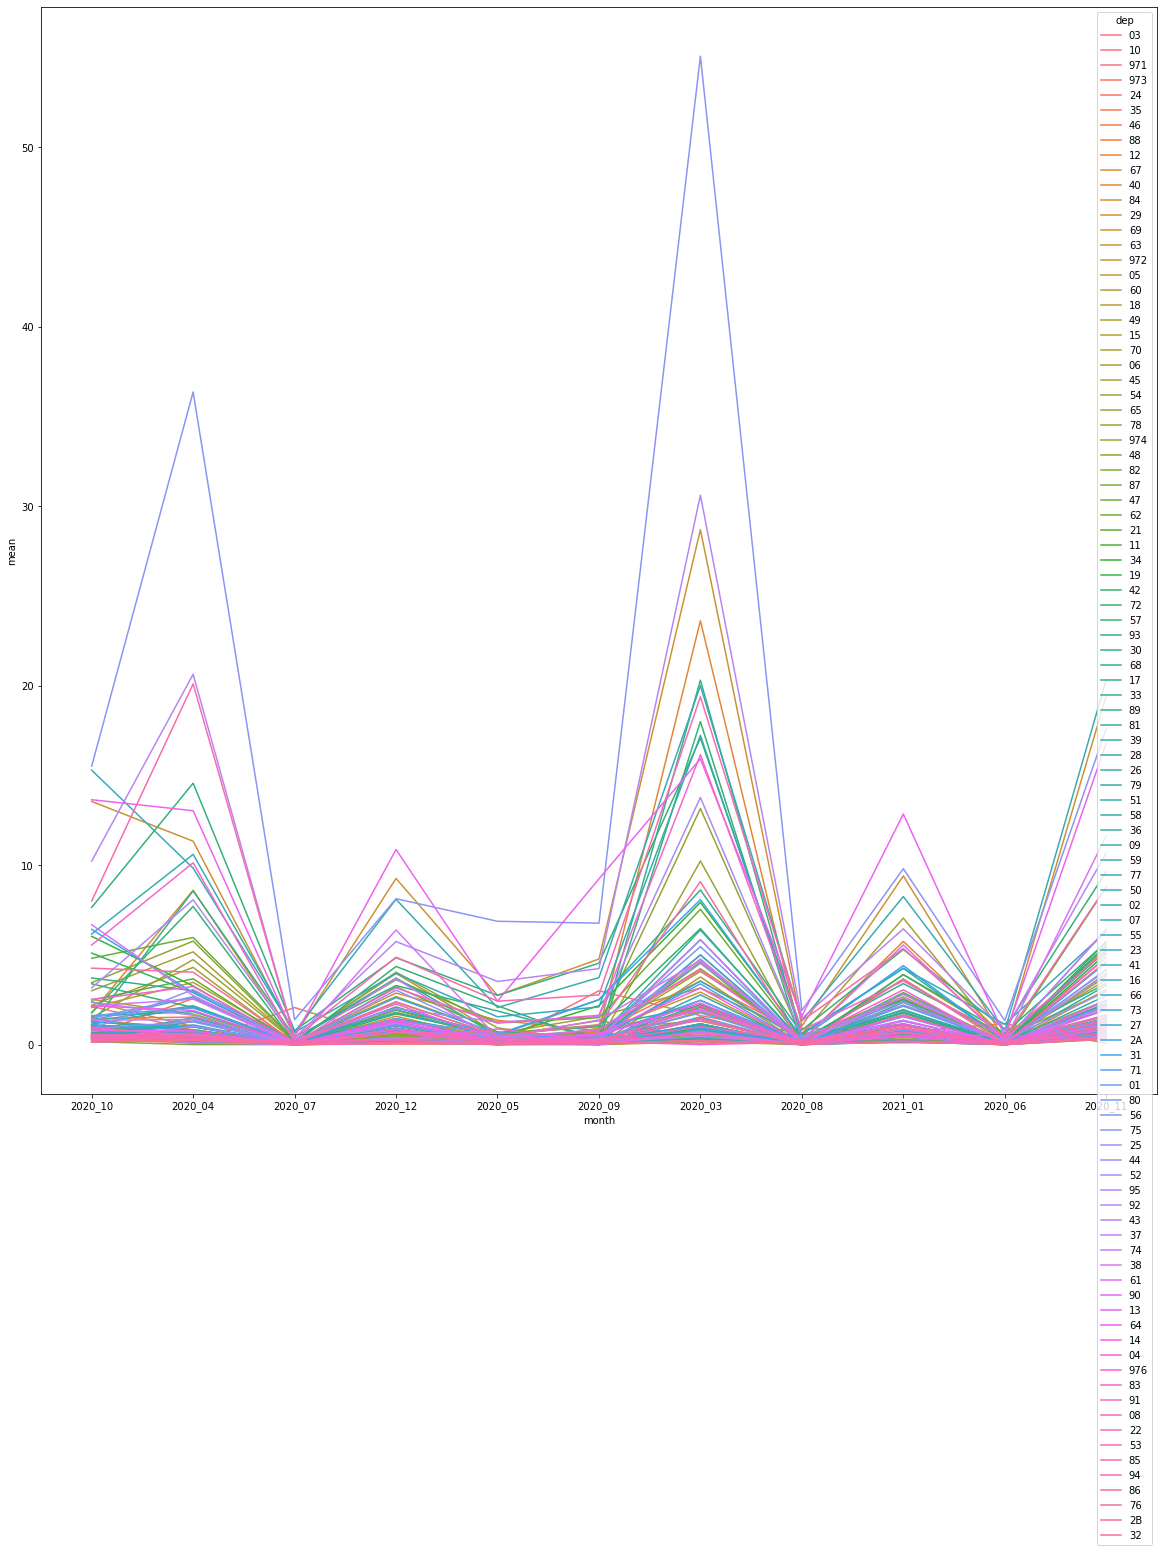

In [24]:
result = (df.groupBy(F.date_format('jour', 'yyyy_MM').alias('month'), 'dep')
.agg(F.avg('incid_rea').alias('mean'))
)
result.toPandas().reset_index()
plt.figure(figsize=(20,20))
sns.lineplot(data=result.toPandas(), x="month", y="mean", hue="dep")

<AxesSubplot:>

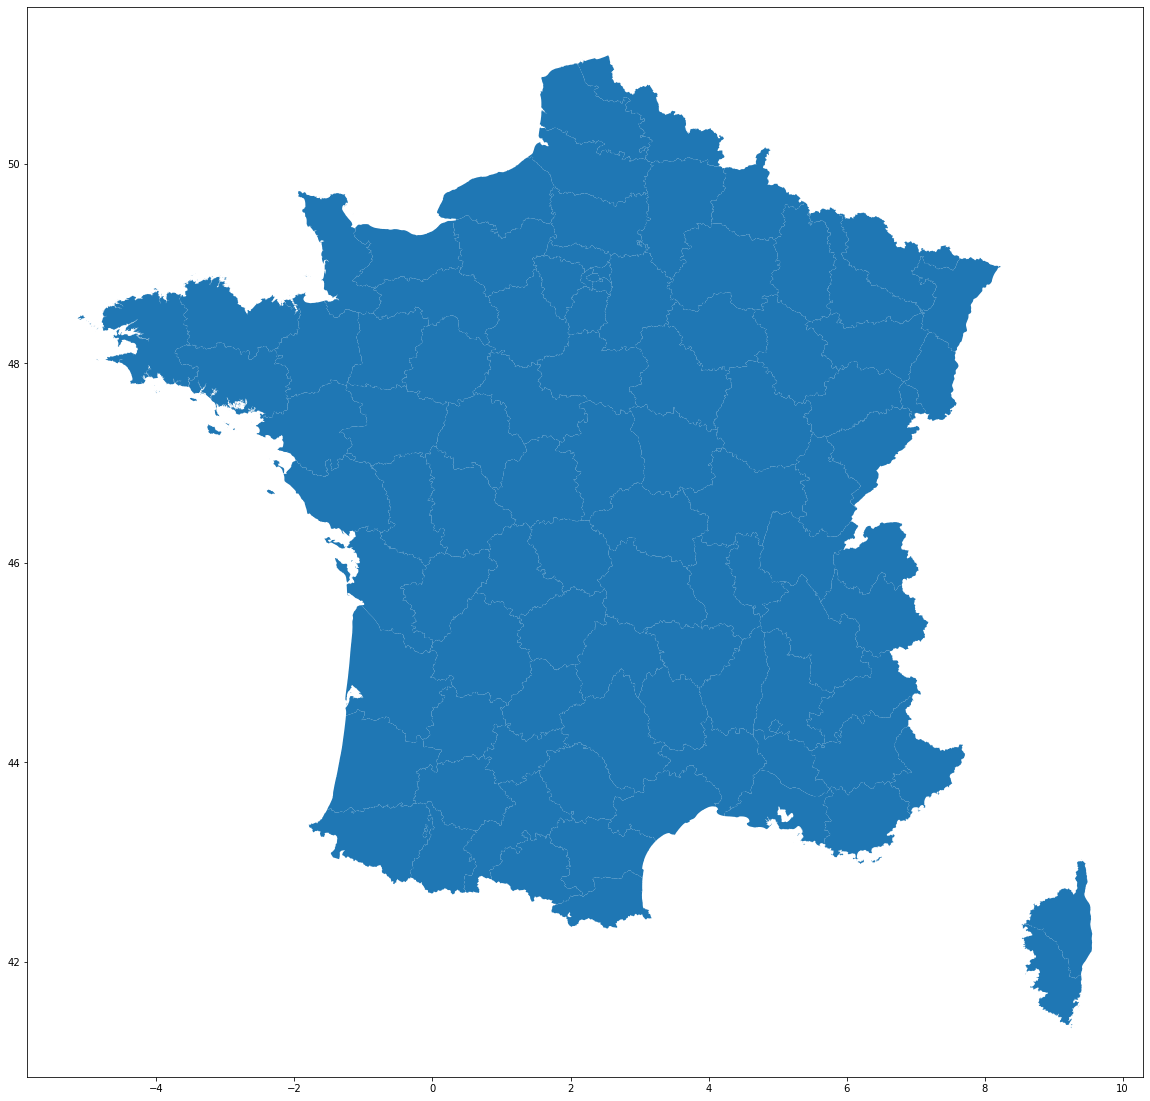

In [7]:
sf = gpd.read_file("./data/departements.geojson")
sf.plot(figsize=(20, 20))